![Rijksoverheid logo](https://www.rijksoverheid.nl/binaries/content/gallery/rijksoverheid/channel-afbeeldingen/logos/logo-ro.svg)

# Dutch Government Policy QA dataset
This dataset is open-source and can be found on the open data portal of the [Rijksoverheid](https://www.rijksoverheid.nl/opendata/vac-s). It contains up to 2500 frequently asked questions of Dutch citizens. The questions are concerned with Dutch government policies and contain topics like "Belasting", "Asbest", or "Klimaat".<br>
More info about the status and contact information can be found [here](https://data.overheid.nl/dataset/vraag-antwoordcombinaties-van-rijksoverheid-nl#panel-description). <br><br>

**How to use:** <br>
It is best to use Google Colab and run the notebook to get results

### In this notebook:
- The Dutch policy QA data is imported via api with a crawler
- Initial EDA is performed to check the size, completeness, and volume
- The neccessary columns are exported as a csv
- A short answer is retrieved manually from the context
- Extra EDA is performed with on the final dataset
- The PolicyQA dataset is converted to the correct input for the QA model by using our DF to JSON converter
- The PolicyQA dataset in JSON format is used as input for the model

In [ ]:
# if using Colab, install necessary libraries
%pip install transformers
!python -m pip install seaborn

In [78]:
# Import libraries
import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import time
import matplotlib as plt
import matplotlib.pyplot as plt

## Import Data
First the data is imported using crawler.py <br>
Then the data is checked for volume, completeness etc.

In [ ]:
# Run crawler
!python3 /scripts/crawler.py

In [14]:
# Import csv
dfraw = pd.read_csv('../data/policyqa-raw.csv')
dfraw.head()

,Unnamed: 0,id,type,canonical,dataurl,question,introduction,content,authorities,subjects,themes,organisationalunits,lastmodified,license,rightsholders,language,location
0,0,b98b7797-7d40-43a7-bc6d-bf7f96d31dd0,vraag en antwoord,https://www.rijksoverheid.nl/onderwerpen/inkom...,https://opendata.rijksoverheid.nl/v1/sources/r...,Hoe lang moet ik mijn financiële administratie...,<p>Voor particulieren geldt geen wettelijke be...,[{'paragraphtitle': 'Geen bewaarplicht voor pa...,['Ministerie van Financiën'],"['Inkomstenbelasting', 'Zelfstandigen zonder p...","['Economie', 'Belastingen, uitkeringen en toes...",['Ministerie van Financiën'],2021-09-06T12:18:10.872Z,CC0 1.0 Universal,['Ministerie van Algemene Zaken'],nl-NL,Nederland
1,0,a59a7ef3-8c7c-4d38-9a6a-142a9fca6eec,vraag en antwoord,https://www.rijksoverheid.nl/onderwerpen/belas...,https://opendata.rijksoverheid.nl/v1/sources/r...,Wat is een belastingverdrag?,<p>Een belastingverdrag is een overeenkomst tu...,[{'paragraphtitle': 'Toepassen van het belasti...,['Ministerie van Financiën'],['Belastingverdragen'],"['Belastingen, uitkeringen en toeslagen', 'Int...",['Ministerie van Financiën'],2020-06-22T13:12:15.045Z,CC0 1.0 Universal,['Ministerie van Algemene Zaken'],nl-NL,Nederland
2,0,193accef-6ff6-4a05-a89c-b6ff37389745,vraag en antwoord,https://www.rijksoverheid.nl/onderwerpen/paspo...,https://opendata.rijksoverheid.nl/v1/sources/r...,Is mijn beschadigde paspoort of identiteitskaa...,<p>Zijn de echtheidskenmerken van uw paspoort ...,[{'paragraphtitle': 'Nieuw reisdocument aanvra...,['Ministerie van Binnenlandse Zaken en Koninkr...,['Paspoort en identiteitskaart'],"['Migratie en reizen', 'Recht, veiligheid en d...",['Ministerie van Binnenlandse Zaken en Koninkr...,2018-01-03T10:05:53.606Z,CC0 1.0 Universal,['Ministerie van Algemene Zaken'],nl-NL,Nederland
3,0,913baae5-4e13-4270-bab2-d8035a15f032,vraag en antwoord,https://www.rijksoverheid.nl/onderwerpen/besch...,https://opendata.rijksoverheid.nl/v1/sources/r...,Moet een bank een kopie van mijn paspoort make...,<p>Banken en financiële dienstverleners zijn n...,[{'paragraphtitle': 'Financiële instelling doe...,['Ministerie van Financiën'],"['Bescherming van consumenten', 'Financiële se...","['Economie', 'Recht, veiligheid en defensie']",['Ministerie van Financiën'],2022-02-04T12:48:50.668Z,CC0 1.0 Universal,['Ministerie van Algemene Zaken'],nl-NL,Nederland
4,0,1c255df3-9d57-4d26-a4d9-7637b54d47e6,vraag en antwoord,https://www.rijksoverheid.nl/onderwerpen/geldz...,https://opendata.rijksoverheid.nl/v1/sources/r...,Waarom is de euro ingevoerd?,<p>Er zijn een aantal redenen voor de invoerin...,[{'paragraphtitle': 'Einde aan schommelende wi...,['Ministerie van Financiën'],"['Geldzaken', 'Financiën Europese Unie']","['Economie', 'Internationale samenwerking']",['Ministerie van Financiën'],2021-08-24T08:34:50.465Z,CC0 1.0 Universal,['Ministerie van Algemene Zaken'],nl-NL,Nederland


## Initial EDA
EDA performed on the raw data

In [15]:
# Check info
dfraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1988 non-null   int64 
 1   id                   1988 non-null   object
 2   type                 1988 non-null   object
 3   canonical            1988 non-null   object
 4   dataurl              1988 non-null   object
 5   question             1988 non-null   object
 6   introduction         1981 non-null   object
 7   content              1917 non-null   object
 8   authorities          1988 non-null   object
 9   subjects             1978 non-null   object
 10  themes               1978 non-null   object
 11  organisationalunits  1988 non-null   object
 12  lastmodified         1988 non-null   object
 13  license              1988 non-null   object
 14  rightsholders        1988 non-null   object
 15  language             1988 non-null   object
 16  locati

In [67]:
dfraw['content'][0]

'[{\'paragraphtitle\': \'Geen bewaarplicht voor particulieren\', \'paragraph\': \'<p>Particulieren hoeven hun administratieve gegevens (zoals bankafschriften en loonstrookjes) niet verplicht te bewaren. Maar de Belastingdienst mag tot 5 jaar terug belasting navorderen. Daarom is het verstandig om uw administratie in ieder geval 5 jaar te bewaren. Dan heeft u bewijs als u het niet eens bent met de navordering.</p>\'}, {\'paragraphtitle\': \'Bewaarplicht financiële gegevens van bedrijven\', \'paragraph\': \'<p>Bedrijven en zelfstandigen moeten hun administratie 7 jaar bewaren. Dit staat in de wet. Er zijn ook gegevens die een bedrijf 10 jaar moet bewaren. Op de website van de Belastingdienst staat <a href="https://www.belastingdienst.nl/wps/wcm/connect/bldcontentnl/belastingdienst/zakelijk/btw/administratie_bijhouden/administratie_bewaren/">welke administratieve gegevens u moet bewaren en hoe lang</a>.</p>\'}]'

## Raw conclusion
* By inspecting the data we can see the actual answer does only appear in the Introduction column for around 50% of the time.
* The actual answer is always in the Introduction column and the Content column is supplementary to the answer.
* Therefor the data is exported with the necessary columns
* We add supplementary annotations by adding a short answer, which is derived from the Introduction column (the actual answer, supplied by domain experts)

In [ ]:
# Take first 7 columns
dfraw = dfraw.iloc[:, 0:7]
# Remove column 3 and 4
dfraw = dfraw.drop(columns=["canonical", "dataurl"])
# Export to csv
dfraw.to_csv('policyqa-raw.csv', encoding = 'utf-8-sig') 

## EDA
The annotated data is added manually. <br>
To convert the annotated data to a clean dataset, we call scripts/converter.py
This script:
- removes non-alphanumeric characters
- add all answer start character positions
- converts the Dataframe to the correct model input, which is saved at data/dataV3.json

In [ ]:
# Run crawler
!python3 /scripts/converter.py

In [47]:
# Read annotated cleaned csv
df = pd.read_csv('../data/policyqa-annotated-clean.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,id,type,answer_start,answer_short,question,introductioncontent,introduction,content
0,0,0,b98b7797-7d40-43a7-bc6d-bf7f96d31dd0,vraag en antwoord,133,5 jaar te bewaren,Hoe lang moet ik mijn financiële administratie...,voor particulieren geldt geen wettelijke bewaa...,<p>Voor particulieren geldt geen wettelijke be...,[{'paragraphtitle': 'Geen bewaarplicht voor pa...
1,1,0,a59a7ef3-8c7c-4d38-9a6a-142a9fca6eec,vraag en antwoord,28,overeenkomst tussen 2 landen,Wat is een belastingverdrag?,een belastingverdrag is een overeenkomst tusse...,<p>Een belastingverdrag is een overeenkomst tu...,[{'paragraphtitle': 'Toepassen van het belasti...
2,2,0,193accef-6ff6-4a05-a89c-b6ff37389745,vraag en antwoord,87,gegevens slecht leesbaar? dan is uw reisdocume...,Is mijn beschadigde paspoort of identiteitskaa...,zijn de echtheidskenmerken van uw paspoort of ...,<p>Zijn de echtheidskenmerken van uw paspoort ...,[{'paragraphtitle': 'Nieuw reisdocument aanvra...
3,3,0,913baae5-4e13-4270-bab2-d8035a15f032,vraag en antwoord,42,niet verplicht om een kopie of een scan van uw...,Moet een bank een kopie van mijn paspoort make...,banken en financiële dienstverleners zijn niet...,<p>Banken en financiële dienstverleners zijn n...,[{'paragraphtitle': 'Financiële instelling doe...
4,4,0,1c255df3-9d57-4d26-a4d9-7637b54d47e6,vraag en antwoord,220,makkelijker om prijzen te vergelijken,Waarom is de euro ingevoerd?,er zijn een aantal redenen voor de invoering v...,<p>Er zijn een aantal redenen voor de invoerin...,[{'paragraphtitle': 'Einde aan schommelende wi...


In [48]:
# Drop first 2 columns
df = df.iloc[: , 2:]

,id,type,answer_start,answer_short,question,introductioncontent,introduction,content
0,b98b7797-7d40-43a7-bc6d-bf7f96d31dd0,vraag en antwoord,133,5 jaar te bewaren,Hoe lang moet ik mijn financiële administratie...,voor particulieren geldt geen wettelijke bewaa...,<p>Voor particulieren geldt geen wettelijke be...,[{'paragraphtitle': 'Geen bewaarplicht voor pa...
1,a59a7ef3-8c7c-4d38-9a6a-142a9fca6eec,vraag en antwoord,28,overeenkomst tussen 2 landen,Wat is een belastingverdrag?,een belastingverdrag is een overeenkomst tusse...,<p>Een belastingverdrag is een overeenkomst tu...,[{'paragraphtitle': 'Toepassen van het belasti...
2,193accef-6ff6-4a05-a89c-b6ff37389745,vraag en antwoord,87,gegevens slecht leesbaar? dan is uw reisdocume...,Is mijn beschadigde paspoort of identiteitskaa...,zijn de echtheidskenmerken van uw paspoort of ...,<p>Zijn de echtheidskenmerken van uw paspoort ...,[{'paragraphtitle': 'Nieuw reisdocument aanvra...
3,913baae5-4e13-4270-bab2-d8035a15f032,vraag en antwoord,42,niet verplicht om een kopie of een scan van uw...,Moet een bank een kopie van mijn paspoort make...,banken en financiële dienstverleners zijn niet...,<p>Banken en financiële dienstverleners zijn n...,[{'paragraphtitle': 'Financiële instelling doe...
4,1c255df3-9d57-4d26-a4d9-7637b54d47e6,vraag en antwoord,220,makkelijker om prijzen te vergelijken,Waarom is de euro ingevoerd?,er zijn een aantal redenen voor de invoering v...,<p>Er zijn een aantal redenen voor de invoerin...,[{'paragraphtitle': 'Einde aan schommelende wi...


#### Charts for dataset statistics
- Number of characters
- Number of words

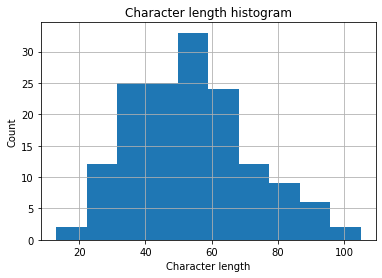

In [96]:
def plot_character_length_histogram(text):
    text.str.len().\
        hist().set(xlabel='Character length', ylabel='Count', title='Character length histogram')

plot_character_length_histogram(df['question'])

The histogram shows that questions range from 10 to 100 characters and generally, it is between 30 and 70 characters

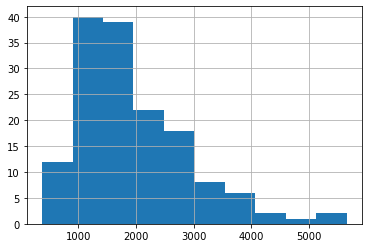

In [65]:
plot_character_length_histogram(df['introductioncontent'])

The histogram shows that questions range from 300 to 5800 characters and generally, it is between 900 and 1900 characters

<AxesSubplot:>

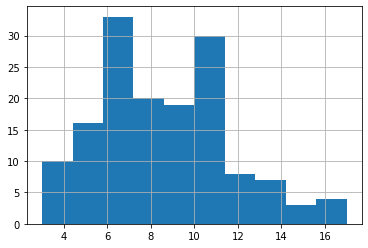

In [69]:
df['question'].str.split().\
    map(lambda x: len(x)).\
    hist()

# we can see that the number of words range from 3 to 15

<AxesSubplot:>

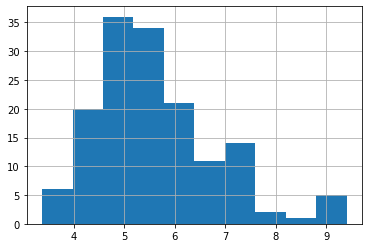

In [71]:
df['question'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

# The average word lenght is 5.5

In [72]:
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('dutch'))

[nltk_data] Downloading package stopwords to /Users/berry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
corpus=[]
new= df['question'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [74]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('dutch'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

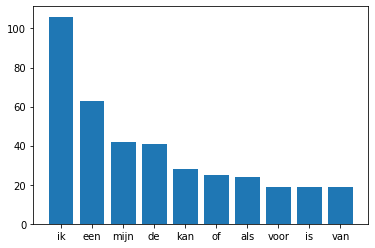

In [79]:
plot_top_stopwords_barchart(df['question'])
# We can see that stopwords like Ik (I), een (a), mijn (my), etc. are the most frequent stopwords.

In [60]:
# Code Snippet for Top Non-Stopwords Barchart

import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('dutch'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x).set(title='Top Non-Stopwords')

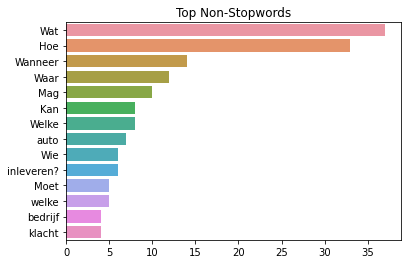

In [61]:
plot_top_non_stopwords_barchart(df['question'])

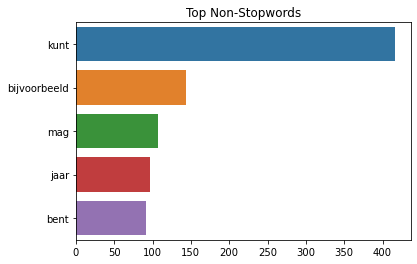

In [87]:
plot_top_non_stopwords_barchart(df['introductioncontent'])

We can see paragraph and paragraphtitle are common words. These do not add any meaning to the text, so let's remove them. Also the colon (:) and the word title do not add meaning to the text, so we remove those words as well.

In [83]:
df['introductioncontent'] = df['introductioncontent'].str.replace(r'paragraph', '', regex=True)
df['introductioncontent'] = df['introductioncontent'].str.replace(r'paragraphtitle', '', regex=True)
df['introductioncontent'] = df['introductioncontent'].str.replace(r':', '', regex=True)
df['introductioncontent'] = df['introductioncontent'].str.replace(r'title', '', regex=True)